In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import time

import pulp

In [4]:
import sys
sys.path.insert(0, '../..')

import quan_utils

# Unconstrained (fairness-wise) IP solution

In [3]:
helper = quan_utils.AssignmentHelper()
helper.update_constraints()

In [4]:
t0 = time.time()
sol_df = helper.ip_solve()
print(f'Took {time.time() - t0:.4f} seconds')
sol_df.head()

Took 21.8209 seconds


,ES,PSH,TH,RRH,PREV
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0


In [5]:
print(helper.prob.objective.value())
pulp.LpStatus[helper.prob.status]

3627.0456566409853


'Optimal'

In [6]:
helper.prob_df[helper.types].min(axis=1).sum()

2497.9808768479998

In [7]:
real_n_reentries, bart_n_reentries, uncon_sol_n_reentries = helper.compare_reentry(sol_df)
print(f'Percentage reduction in reentry probability: {(real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100}')

prob_compare_df = helper.compare_prob(sol_df)
print(f'Max increase in reentry probability: {prob_compare_df["Input_to_real"].max()}')
print(f'Mean positive increase in reentry probability: {prob_compare_df[prob_compare_df["Input_to_real"] > 0]["Input_to_real"].mean()}')

Total number of reentered households: 4082
BART-estimated: 4085.7049
Input assignment: 3627.0457
Percentage reduction in reentry probability: 11.14537832824632
Max increase in reentry probability: 0.48047754
Mean positive increase in reentry probability: 0.05368681286646232


### Difference between IP-produced and original allocations

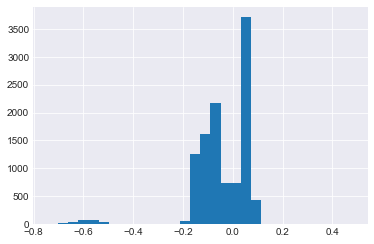

In [8]:
prob_compare_df = helper.compare_prob(sol_df)

plt.hist(prob_compare_df[prob_compare_df['Input_to_real'] != 0]['Input_to_real'], bins=30)
plt.show()


### Difference between IP-produced to individual-best allocations

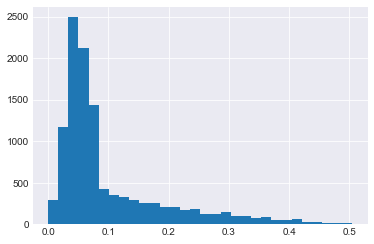

In [9]:
prob_compare_df = helper.compare_prob(sol_df)

plt.hist(prob_compare_df[prob_compare_df['Input_to_best'] != 0]['Input_to_best'], bins=30)
plt.show()

### Difference between original and individual-best allocations

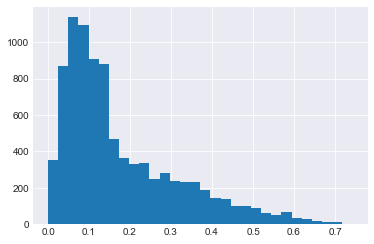

In [10]:
prob_compare_df = helper.compare_prob(sol_df)

plt.hist(prob_compare_df[prob_compare_df['Real_to_best'] != 0]['Real_to_best'], bins=30)
plt.show()

In [11]:
prob_compare_df.head()

,Real,Input assignment,Input_to_real,Input_to_best,Real_to_best
1,0.271801,0.291637,0.0198355,0.0198355,0
2,0.188743,0.218234,0.0294906,0.0294906,0
3,0.760772,0.137805,-0.622967,0.0316368,0.654604
4,0.21769,0.183896,-0.0337943,0.0356027,0.0693969
5,0.554693,0.232651,-0.322042,0.0423299,0.364372


# Different fairness constraints

In [10]:
fairness_constraints = [i / 100 for i in range(11)]
percentage_reductions = []
max_prob_diff = []
avg_pos_prob_increase = []
thirdq_pos_prob_increase = []
range_prob_diff = []
thirdq_pos_dist_from_best = []

for constraint in fairness_constraints:
    print(f'Processing constraint {constraint}')
    
    helper = quan_utils.AssignmentHelper()
    helper.update_constraints(fairness_constraint=constraint)
    
    sol_df = helper.ip_solve()
    real_n_reentries, bart_n_reentries, sol_n_reentries = helper.compare_reentry(sol_df, verbose=False)
    prob_compare_df = helper.compare_prob(sol_df)
    
    percentage_reductions.append(
        (real_n_reentries - sol_n_reentries) / real_n_reentries * 100
    )
    max_prob_diff.append(prob_compare_df['Diff'].max())
    avg_pos_prob_increase.append(prob_compare_df[prob_compare_df["Diff"] > 0]["Diff"].mean())
    thirdq_pos_prob_increase.append(prob_compare_df[prob_compare_df["Diff"] > 0]["Diff"].quantile(0.75))
    range_prob_diff.append(prob_compare_df['Diff'].max() - prob_compare_df['Diff'].min())
    thirdq_pos_dist_from_best.append(prob_compare_df[prob_compare_df['Dist_from_best'] > 0]['Dist_from_best'].quantile(0.75))

Processing constraint 0.0
Processing constraint 0.01
Processing constraint 0.02
Processing constraint 0.03
Processing constraint 0.04
Processing constraint 0.05
Processing constraint 0.06
Processing constraint 0.07
Processing constraint 0.08
Processing constraint 0.09
Processing constraint 0.1


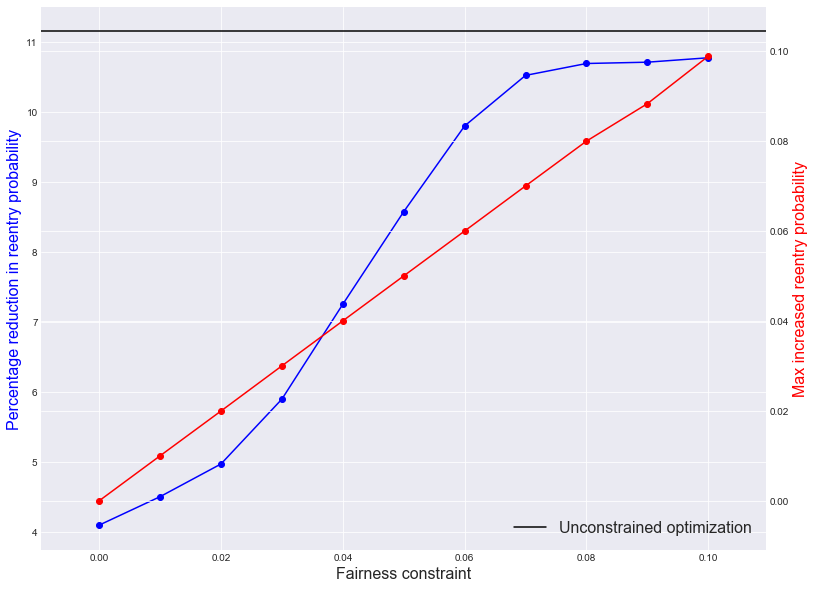

In [11]:
f, ax1 = plt.subplots(figsize=(13, 10))

# Utility: reentry probability percent reduction
ax1.axhline(
    (real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100,
    c='black',
    label='Unconstrained optimization'
)
ax1.scatter(fairness_constraints, percentage_reductions, c='blue')
ax1.plot(fairness_constraints, percentage_reductions, c='blue')

ax1.set_xlabel('Fairness constraint', fontsize=16)
ax1.set_ylabel('Percentage reduction in reentry probability', color='blue', fontsize=16)

# Fairness: max increased reentry probability
ax2 = ax1.twinx()
ax2.scatter(fairness_constraints, max_prob_diff, c='red')
ax2.plot(fairness_constraints, max_prob_diff, c='red')

ax2.set_ylabel('Max increased reentry probability', color='red', fontsize=16)

ax1.legend(loc='lower right', fontsize=16)
plt.show()

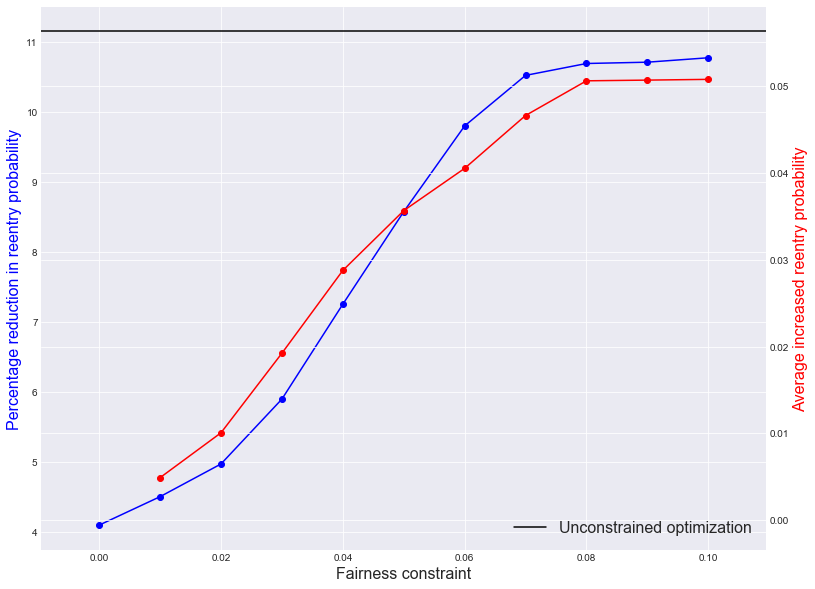

In [12]:
f, ax1 = plt.subplots(figsize=(13, 10))

# Utility: reentry probability percent reduction
ax1.axhline(
    (real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100,
    c='black',
    label='Unconstrained optimization'
)
ax1.scatter(fairness_constraints, percentage_reductions, c='blue')
ax1.plot(fairness_constraints, percentage_reductions, c='blue')

ax1.set_xlabel('Fairness constraint', fontsize=16)
ax1.set_ylabel('Percentage reduction in reentry probability', color='blue', fontsize=16)

# Fairness: average increased reentry probability
ax2 = ax1.twinx()
ax2.scatter(fairness_constraints, avg_pos_prob_increase, c='red')
ax2.plot(fairness_constraints, avg_pos_prob_increase, c='red')

ax2.set_ylabel('Average increased reentry probability', color='red', fontsize=16)

ax1.legend(loc='lower right', fontsize=16)
plt.show()

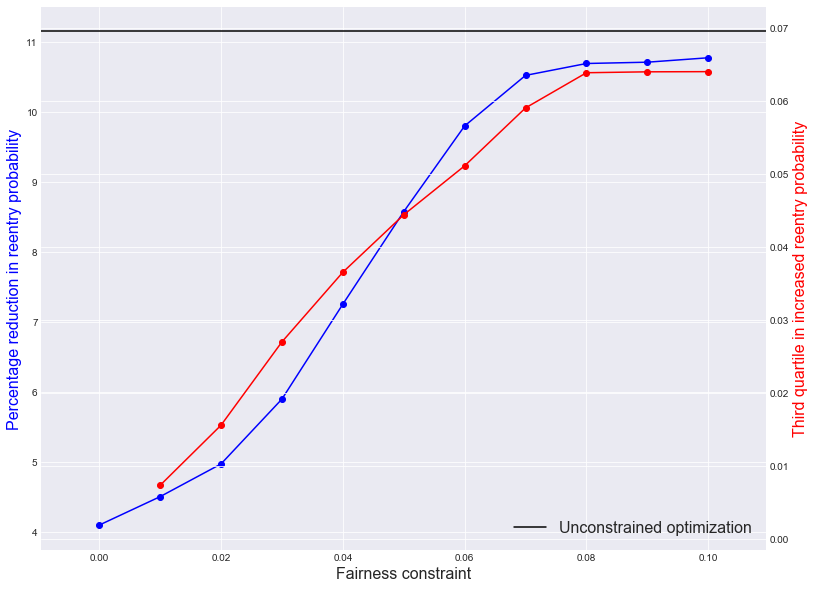

In [13]:
f, ax1 = plt.subplots(figsize=(13, 10))

# Utility: reentry probability percent reduction
ax1.axhline(
    (real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100,
    c='black',
    label='Unconstrained optimization'
)
ax1.scatter(fairness_constraints, percentage_reductions, c='blue')
ax1.plot(fairness_constraints, percentage_reductions, c='blue')

ax1.set_xlabel('Fairness constraint', fontsize=16)
ax1.set_ylabel('Percentage reduction in reentry probability', color='blue', fontsize=16)

# Fairness: average increased reentry probability
ax2 = ax1.twinx()
ax2.scatter(fairness_constraints, thirdq_pos_prob_increase, c='red')
ax2.plot(fairness_constraints, thirdq_pos_prob_increase, c='red')

ax2.set_ylabel('Third quartile in increased reentry probability', color='red', fontsize=16)

ax1.legend(loc='lower right', fontsize=16)
plt.show()

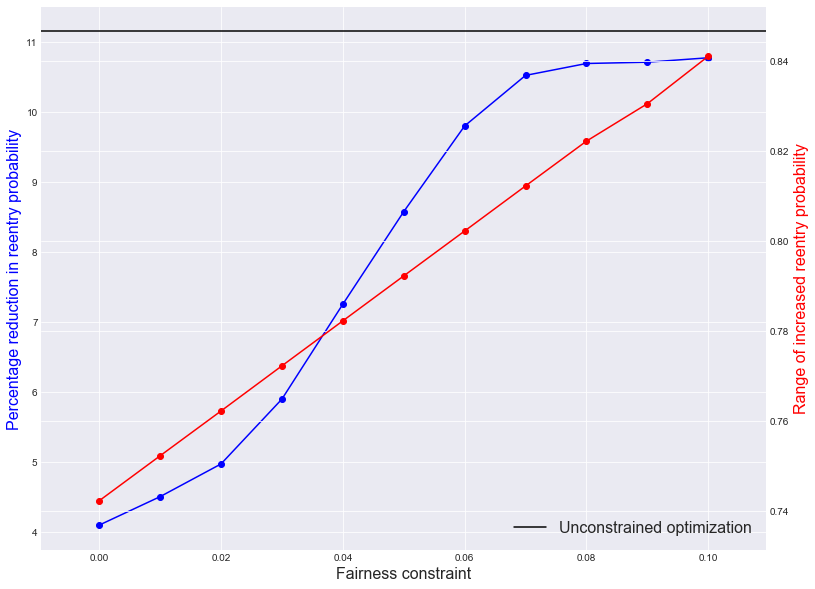

In [14]:
f, ax1 = plt.subplots(figsize=(13, 10))

# Utility: reentry probability percent reduction
ax1.axhline(
    (real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100,
    c='black',
    label='Unconstrained optimization'
)
ax1.scatter(fairness_constraints, percentage_reductions, c='blue')
ax1.plot(fairness_constraints, percentage_reductions, c='blue')

ax1.set_xlabel('Fairness constraint', fontsize=16)
ax1.set_ylabel('Percentage reduction in reentry probability', color='blue', fontsize=16)

# Fairness: average increased reentry probability
ax2 = ax1.twinx()
ax2.scatter(fairness_constraints, range_prob_diff, c='red')
ax2.plot(fairness_constraints, range_prob_diff, c='red')

ax2.set_ylabel('Range of increased reentry probability', color='red', fontsize=16)

ax1.legend(loc='lower right', fontsize=16)
plt.show()

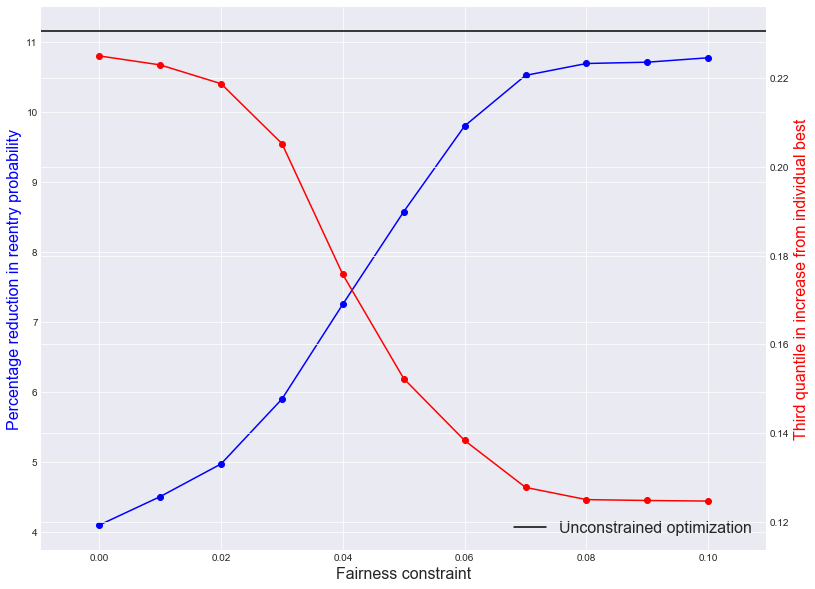

In [15]:
f, ax1 = plt.subplots(figsize=(13, 10))

# Utility: reentry probability percent reduction
ax1.axhline(
    (real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100,
    c='black',
    label='Unconstrained optimization'
)
ax1.scatter(fairness_constraints, percentage_reductions, c='blue')
ax1.plot(fairness_constraints, percentage_reductions, c='blue')

ax1.set_xlabel('Fairness constraint', fontsize=16)
ax1.set_ylabel('Percentage reduction in reentry probability', color='blue', fontsize=16)

# Fairness: average increased reentry probability
ax2 = ax1.twinx()
ax2.scatter(fairness_constraints, thirdq_pos_dist_from_best, c='red')
ax2.plot(fairness_constraints, thirdq_pos_dist_from_best, c='red')

ax2.set_ylabel('Third quantile in increase from individual best', color='red', fontsize=16)

ax1.legend(loc='lower right', fontsize=16)
plt.show()

# Boxplots

In [5]:
fairness_constraints = [i * 2 / 100 for i in range(11)]
percentage_reductions = []
input_to_real_df = pd.DataFrame(columns=fairness_constraints)
input_to_best_df = pd.DataFrame(columns=fairness_constraints)

for constraint in fairness_constraints:
    print(f'Processing constraint {constraint}')
    
    helper = quan_utils.AssignmentHelper()
    helper.update_constraints(fairness_constraint=constraint)
    
    sol_df = helper.ip_solve()
    print(pulp.LpStatus[helper.prob.status])
    real_n_reentries, bart_n_reentries, sol_n_reentries = helper.compare_reentry(sol_df, verbose=False)
    prob_compare_df = helper.compare_prob(sol_df)
    
    percentage_reductions.append(
        (real_n_reentries - sol_n_reentries) / real_n_reentries * 100
    )
    input_to_real_df[constraint] = prob_compare_df['Input_to_real']
    input_to_best_df[constraint] = prob_compare_df['Input_to_best']

Processing constraint 0.0
Optimal
Processing constraint 0.02
Optimal
Processing constraint 0.04
Optimal
Processing constraint 0.06
Optimal
Processing constraint 0.08
Optimal
Processing constraint 0.1
Optimal
Processing constraint 0.12
Optimal
Processing constraint 0.14
Optimal
Processing constraint 0.16
Optimal
Processing constraint 0.18
Optimal
Processing constraint 0.2
Optimal


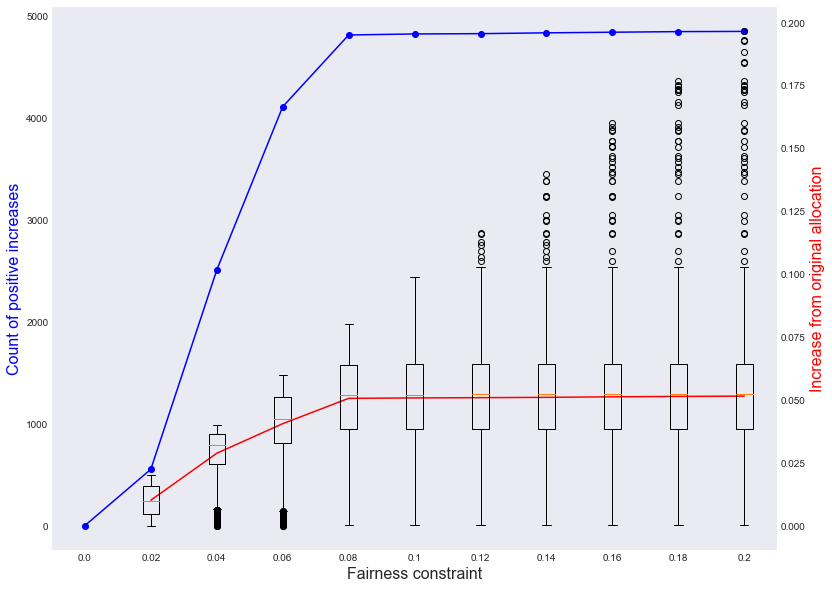

In [27]:
f, ax1 = plt.subplots(figsize=(13, 10))

# # Utility: reentry probability percent reduction
# ax1.axhline(
#     (real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100,
#     c='black',
#     label='Unconstrained optimization'
# )
# ax1.scatter(fairness_constraints, percentage_reductions, c='blue')
# ax1.plot(fairness_constraints, percentage_reductions, c='blue')

# ax1.set_xlabel('Fairness constraint', fontsize=16)
# ax1.set_ylabel('Percentage reduction in reentry probability', color='blue', fontsize=16)

# Count of increased reentry probability
ax1.scatter(
    fairness_constraints,
    input_to_real_df[input_to_real_df > 0].count(),
    c='blue'
)
ax1.plot(
    fairness_constraints,
    input_to_real_df[input_to_real_df > 0].count(),
    c='blue'
)
ax1.set_xlabel('Fairness constraint', fontsize=16)
ax1.set_ylabel('Count of positive increases', color='blue', fontsize=16)

# Fairness: Increased reentry probability from the original allocation
ax2 = ax1.twinx()
# ax2.boxplot(input_to_real_df.to_numpy(), positions=fairness_constraints)
ax2.plot(
    fairness_constraints,
    input_to_real_df[input_to_real_df > 0].mean(),
    c='red'
)

for constraint in fairness_constraints:
    ax2.boxplot(
        input_to_real_df[input_to_real_df[constraint] > 0][constraint],
        positions=[constraint],
        widths=[0.005]
    )

ax2.set_ylabel('Increase from original allocation', color='red', fontsize=16)

ax1.set_xlim(min(fairness_constraints) - 0.01, max(fairness_constraints) + 0.01)
plt.show()

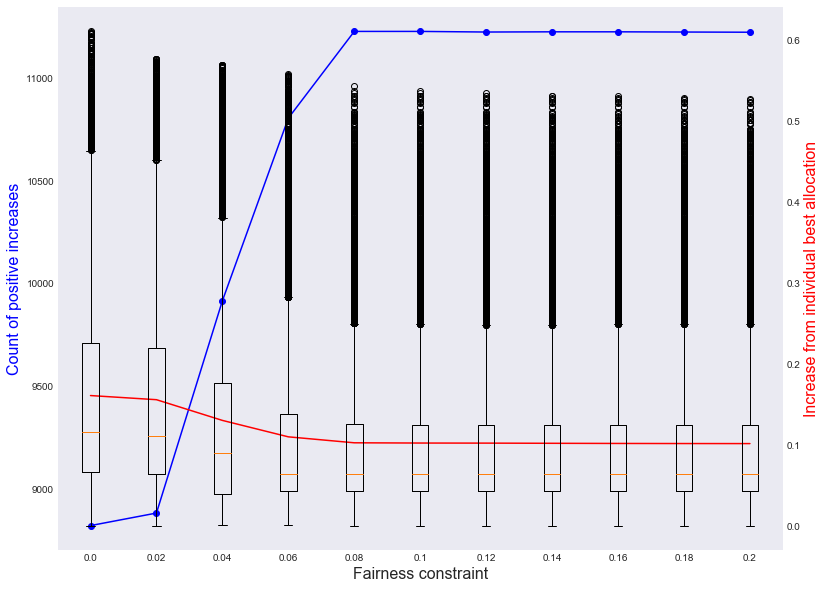

In [25]:
f, ax1 = plt.subplots(figsize=(13, 10))

# # Utility: reentry probability percent reduction
# ax1.axhline(
#     (real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100,
#     c='black',
#     label='Unconstrained optimization'
# )
# ax1.scatter(fairness_constraints, percentage_reductions, c='blue')
# ax1.plot(fairness_constraints, percentage_reductions, c='blue')

# ax1.set_xlabel('Fairness constraint', fontsize=16)
# ax1.set_ylabel('Percentage reduction in reentry probability', color='blue', fontsize=16)

# Count of increased reentry probability
ax1.scatter(
    fairness_constraints,
    input_to_best_df[input_to_best_df > 0].count(),
    c='blue'
)
ax1.plot(
    fairness_constraints,
    input_to_best_df[input_to_best_df > 0].count(),
    c='blue'
)
ax1.set_xlabel('Fairness constraint', fontsize=16)
ax1.set_ylabel('Count of positive increases', color='blue', fontsize=16)

# Fairness: Increased reentry probability from the best unconstrained allocation
ax2 = ax1.twinx()
# ax2.boxplot(input_to_real_df.to_numpy(), positions=fairness_constraints)
ax2.plot(
    fairness_constraints,
    input_to_best_df[input_to_best_df > 0].mean(),
    c='red'
)

for constraint in fairness_constraints:
    ax2.boxplot(
        input_to_best_df[input_to_best_df[constraint] > 0][constraint],
        positions=[constraint],
        widths=[0.005]
    )

ax2.set_ylabel('Increase from individual best allocation', color='red', fontsize=16)

ax1.set_xlim(min(fairness_constraints) - 0.01, max(fairness_constraints) + 0.01)
plt.show()

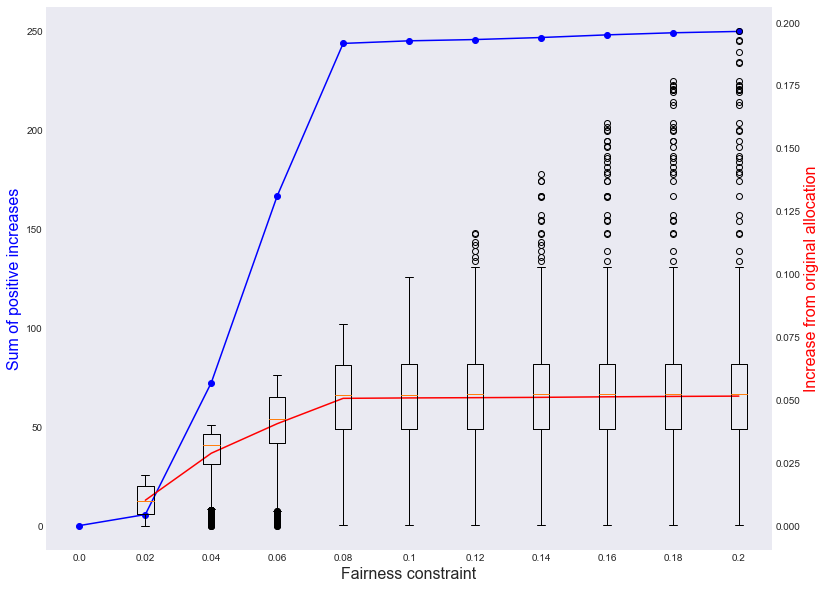

In [26]:
f, ax1 = plt.subplots(figsize=(13, 10))

# # Utility: reentry probability percent reduction
# ax1.axhline(
#     (real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100,
#     c='black',
#     label='Unconstrained optimization'
# )
# ax1.scatter(fairness_constraints, percentage_reductions, c='blue')
# ax1.plot(fairness_constraints, percentage_reductions, c='blue')

# ax1.set_xlabel('Fairness constraint', fontsize=16)
# ax1.set_ylabel('Percentage reduction in reentry probability', color='blue', fontsize=16)

# Count of increased reentry probability
ax1.scatter(
    fairness_constraints,
    input_to_real_df[input_to_real_df > 0].sum(),
    c='blue'
)
ax1.plot(
    fairness_constraints,
    input_to_real_df[input_to_real_df > 0].sum(),
    c='blue'
)
ax1.set_xlabel('Fairness constraint', fontsize=16)
ax1.set_ylabel('Sum of positive increases', color='blue', fontsize=16)

# Fairness: Increased reentry probability from the original allocation
ax2 = ax1.twinx()
# ax2.boxplot(input_to_real_df.to_numpy(), positions=fairness_constraints)
ax2.plot(
    fairness_constraints,
    input_to_real_df[input_to_real_df > 0].mean(),
    c='red'
)

for constraint in fairness_constraints:
    ax2.boxplot(
        input_to_real_df[input_to_real_df[constraint] > 0][constraint],
        positions=[constraint],
        widths=[0.005]
    )

ax2.set_ylabel('Increase from original allocation', color='red', fontsize=16)

ax1.set_xlim(min(fairness_constraints) - 0.01, max(fairness_constraints) + 0.01)
plt.show()

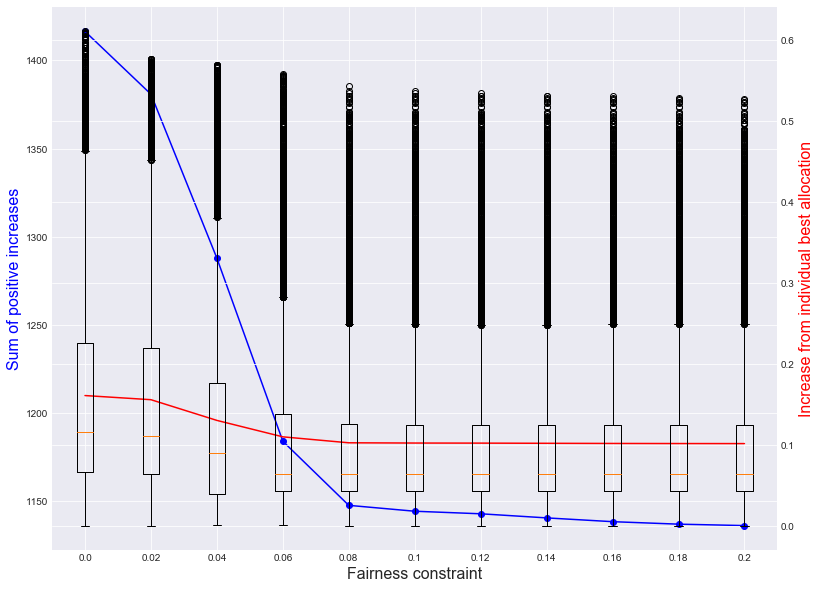

In [25]:
f, ax1 = plt.subplots(figsize=(13, 10))

# # Utility: reentry probability percent reduction
# ax1.axhline(
#     (real_n_reentries - uncon_sol_n_reentries) / real_n_reentries * 100,
#     c='black',
#     label='Unconstrained optimization'
# )
# ax1.scatter(fairness_constraints, percentage_reductions, c='blue')
# ax1.plot(fairness_constraints, percentage_reductions, c='blue')

# ax1.set_xlabel('Fairness constraint', fontsize=16)
# ax1.set_ylabel('Percentage reduction in reentry probability', color='blue', fontsize=16)

# Count of increased reentry probability
ax1.scatter(
    fairness_constraints,
    input_to_best_df[input_to_best_df > 0].sum(),
    c='blue'
)
ax1.plot(
    fairness_constraints,
    input_to_best_df[input_to_best_df > 0].sum(),
    c='blue'
)
ax1.set_xlabel('Fairness constraint', fontsize=16)
ax1.set_ylabel('Sum of positive increases', color='blue', fontsize=16)

# Fairness: Increased reentry probability from the best unconstrained allocation
ax2 = ax1.twinx()
# ax2.boxplot(input_to_real_df.to_numpy(), positions=fairness_constraints)
ax2.plot(
    fairness_constraints,
    input_to_best_df[input_to_best_df > 0].mean(),
    c='red'
)

for constraint in fairness_constraints:
    ax2.boxplot(
        input_to_best_df[input_to_best_df[constraint] > 0][constraint],
        positions=[constraint],
        widths=[0.005]
    )

ax2.set_ylabel('Increase from individual best allocation', color='red', fontsize=16)

ax1.set_xlim(min(fairness_constraints) - 0.01, max(fairness_constraints) + 0.01)
plt.show()